In [57]:
import csv, copy

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import chi2, multivariate_normal

In [58]:
import pandas as pd

df = pd.read_csv('googleplaystore.csv')
df

# Number of points in the data, used for the ranges/iterating through the data
num_data = 10840

In [59]:
df.keys()



Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver',
       'Android Ver'],
      dtype='object')

In [60]:
# Convert num installs to integer
def convertInstallToInt(input):
    input = input.replace(",","")
    mil = False
    if(input[-1] == '+'):
        input = input[:-1]
    if(input[-1] == 'M'):
        input = input[:-1]
        mil = True
    
    out = float(input)
    if mil:
        out = out * 1000000
    out = int(out)
    return out

In [61]:
print(convertInstallToInt("1,000,000+"))
print(convertInstallToInt("1,000+"))
print(convertInstallToInt("50+"))
print(convertInstallToInt("1.3M"))
print(convertInstallToInt("1.6M+"))

1000000
1000
50
1300000
1600000


In [62]:
df['Installs']

0            10,000+
1           500,000+
2         5,000,000+
3        50,000,000+
4           100,000+
5            50,000+
6            50,000+
7         1,000,000+
8         1,000,000+
9            10,000+
10        1,000,000+
11        1,000,000+
12       10,000,000+
13          100,000+
14          100,000+
15            5,000+
16          500,000+
17           10,000+
18        5,000,000+
19       10,000,000+
20          100,000+
21          100,000+
22          500,000+
23          100,000+
24           50,000+
25           10,000+
26          500,000+
27          100,000+
28           10,000+
29          100,000+
            ...     
10810           100+
10811         1,000+
10812        10,000+
10813        50,000+
10814       500,000+
10815           100+
10816       100,000+
10817        10,000+
10818         5,000+
10819         1,000+
10820            50+
10821            10+
10822           100+
10823        10,000+
10824           100+
10825     5,000,000+
10826        

In [63]:
# count = 0
# for i in range(10841):
# #     print(df[i:i+1])
#     count += 1
    
# print(df.loc[10472])
# proportion of reviews to installs
install_proportion = []
for i in range(num_data):
#     install_proportion.append(df.loc[i])
    
    # Pure value
#     print(df.loc[i,"Installs"])
    
    # Check the type (should be str)
#     print(type(df.loc[i,"Installs"]))
    
    # Convert from str to int
#     print(i)
    if np.isnan(df.loc[i,"Rating"]):
        proportion = -1
    else:
        num = int(df.loc[i,"Reviews"]) # .replace(",",""))
        denom = int(df.loc[i,"Installs"][:-1].replace(",",""))
        proportion = num / denom
#     print(proportion)
    install_proportion.append([proportion, df.loc[i,"Price"], denom, df.loc[i, "Category"], df.loc[i, "Type"]])
    
    
#     for key, dat in zip(df.keys(), df.loc[i]):
#         print(key)
#         print(dat)
#         print(df.loc[i,"Installs"])
#         print()
#     print('-------------------------')
    #     print(type(df[0:1][key]))

# [Proportion, Price, Installs, Category, Type]
install_proportion

# df.loc[0][0]

# for i in df.loc[0]:
#     print(i)
# print(count)

[[0.0159, '0', 10000, 'ART_AND_DESIGN', 'Free'],
 [0.001934, '0', 500000, 'ART_AND_DESIGN', 'Free'],
 [0.017502, '0', 5000000, 'ART_AND_DESIGN', 'Free'],
 [0.00431288, '0', 50000000, 'ART_AND_DESIGN', 'Free'],
 [0.00967, '0', 100000, 'ART_AND_DESIGN', 'Free'],
 [0.00334, '0', 50000, 'ART_AND_DESIGN', 'Free'],
 [0.00356, '0', 50000, 'ART_AND_DESIGN', 'Free'],
 [0.036815, '0', 1000000, 'ART_AND_DESIGN', 'Free'],
 [0.013791, '0', 1000000, 'ART_AND_DESIGN', 'Free'],
 [0.0121, '0', 10000, 'ART_AND_DESIGN', 'Free'],
 [0.01388, '0', 1000000, 'ART_AND_DESIGN', 'Free'],
 [0.008788, '0', 1000000, 'ART_AND_DESIGN', 'Free'],
 [0.0044829, '0', 10000000, 'ART_AND_DESIGN', 'Free'],
 [0.04326, '0', 100000, 'ART_AND_DESIGN', 'Free'],
 [0.01518, '0', 100000, 'ART_AND_DESIGN', 'Free'],
 [0.011, '0', 5000, 'ART_AND_DESIGN', 'Free'],
 [0.007264, '0', 500000, 'ART_AND_DESIGN', 'Free'],
 [0.0027, '0', 10000, 'ART_AND_DESIGN', 'Free'],
 [0.0388432, '0', 5000000, 'ART_AND_DESIGN', 'Free'],
 [0.0224399, '0', 10

The mean proportion of users who actually review apps:

In [64]:
mean_prop = np.mean([x[0] for x in install_proportion if x[0] != -1])

Broken down across numbers of installs:

In [65]:
download_counts = {}
for prop in install_proportion:
    if prop[0] != -1:
        if prop[2] not in download_counts.keys():
            download_counts[prop[2]] = [prop[0]]
        else:
            download_counts[prop[2]].append(prop[0])

for count in sorted(download_counts.keys()):
    print(count)

1
5
10
50
100
500
1000
5000
10000
50000
100000
500000
1000000
5000000
10000000
50000000
100000000
500000000
1000000000


# IP Weighting

In [66]:
ip_population = {}

for i in range(num_data):
    if df.loc[i, "Category"] not in ip_population:
        ip_population[df.loc[i, "Category"]] = 1
    else:
        ip_population[df.loc[i, "Category"]] += 1

ip_population = sorted(ip_population.items(), key = 
             lambda kv:(kv[1], kv[0]))

ip_population


[('BEAUTY', 53),
 ('COMICS', 60),
 ('PARENTING', 60),
 ('EVENTS', 64),
 ('ART_AND_DESIGN', 65),
 ('WEATHER', 82),
 ('AUTO_AND_VEHICLES', 85),
 ('LIBRARIES_AND_DEMO', 85),
 ('HOUSE_AND_HOME', 88),
 ('FOOD_AND_DRINK', 127),
 ('MAPS_AND_NAVIGATION', 137),
 ('ENTERTAINMENT', 149),
 ('EDUCATION', 156),
 ('VIDEO_PLAYERS', 175),
 ('BOOKS_AND_REFERENCE', 231),
 ('DATING', 234),
 ('TRAVEL_AND_LOCAL', 258),
 ('SHOPPING', 260),
 ('NEWS_AND_MAGAZINES', 283),
 ('SOCIAL', 295),
 ('PHOTOGRAPHY', 335),
 ('HEALTH_AND_FITNESS', 341),
 ('FINANCE', 366),
 ('LIFESTYLE', 382),
 ('SPORTS', 384),
 ('COMMUNICATION', 387),
 ('PERSONALIZATION', 392),
 ('PRODUCTIVITY', 424),
 ('BUSINESS', 460),
 ('MEDICAL', 463),
 ('TOOLS', 843),
 ('GAME', 1144),
 ('FAMILY', 1972)]

In [67]:
# Get the probabilities from this sample
for pop in ip_population:
    print("Pr[category={}]: ".format(pop[0]), pop[1]/num_data)


Pr[category=BEAUTY]:  0.00488929889298893
Pr[category=COMICS]:  0.005535055350553505
Pr[category=PARENTING]:  0.005535055350553505
Pr[category=EVENTS]:  0.005904059040590406
Pr[category=ART_AND_DESIGN]:  0.005996309963099631
Pr[category=WEATHER]:  0.0075645756457564575
Pr[category=AUTO_AND_VEHICLES]:  0.007841328413284132
Pr[category=LIBRARIES_AND_DEMO]:  0.007841328413284132
Pr[category=HOUSE_AND_HOME]:  0.008118081180811807
Pr[category=FOOD_AND_DRINK]:  0.011715867158671586
Pr[category=MAPS_AND_NAVIGATION]:  0.012638376383763838
Pr[category=ENTERTAINMENT]:  0.013745387453874538
Pr[category=EDUCATION]:  0.014391143911439114
Pr[category=VIDEO_PLAYERS]:  0.01614391143911439
Pr[category=BOOKS_AND_REFERENCE]:  0.021309963099630996
Pr[category=DATING]:  0.02158671586715867
Pr[category=TRAVEL_AND_LOCAL]:  0.023800738007380074
Pr[category=SHOPPING]:  0.023985239852398525
Pr[category=NEWS_AND_MAGAZINES]:  0.0261070110701107
Pr[category=SOCIAL]:  0.0272140221402214
Pr[category=PHOTOGRAPHY]:  0

In [68]:
# Add the free and paid counts values to each category
for i in range(len(ip_population)):
    free_paid = [0, 0]
    for app in install_proportion:
        if app[3] == ip_population[i][0]:
            if app[4] == 'Free':
                free_paid[0] += 1
            elif app[4] == 'Paid':
                free_paid[1] += 1
    ip_population[i] = ip_population[i] + tuple(free_paid)
    
ip_population
            
    

[('BEAUTY', 53, 53, 0),
 ('COMICS', 60, 60, 0),
 ('PARENTING', 60, 58, 2),
 ('EVENTS', 64, 63, 1),
 ('ART_AND_DESIGN', 65, 62, 3),
 ('WEATHER', 82, 74, 8),
 ('AUTO_AND_VEHICLES', 85, 82, 3),
 ('LIBRARIES_AND_DEMO', 85, 84, 1),
 ('HOUSE_AND_HOME', 88, 88, 0),
 ('FOOD_AND_DRINK', 127, 125, 2),
 ('MAPS_AND_NAVIGATION', 137, 132, 5),
 ('ENTERTAINMENT', 149, 147, 2),
 ('EDUCATION', 156, 152, 4),
 ('VIDEO_PLAYERS', 175, 171, 4),
 ('BOOKS_AND_REFERENCE', 231, 203, 28),
 ('DATING', 234, 227, 7),
 ('TRAVEL_AND_LOCAL', 258, 246, 12),
 ('SHOPPING', 260, 258, 2),
 ('NEWS_AND_MAGAZINES', 283, 281, 2),
 ('SOCIAL', 295, 292, 3),
 ('PHOTOGRAPHY', 335, 313, 22),
 ('HEALTH_AND_FITNESS', 341, 325, 16),
 ('FINANCE', 366, 349, 17),
 ('LIFESTYLE', 382, 363, 19),
 ('SPORTS', 384, 360, 24),
 ('COMMUNICATION', 387, 360, 27),
 ('PERSONALIZATION', 392, 309, 83),
 ('PRODUCTIVITY', 424, 396, 28),
 ('BUSINESS', 460, 446, 14),
 ('MEDICAL', 463, 354, 109),
 ('TOOLS', 843, 765, 78),
 ('GAME', 1144, 1061, 83),
 ('FAMIL

In [69]:
# Get the probabilities that an app is free or paid given its category
for app in ip_population:
    free_prob = app[2]/(app[2] + app[3])
    print("Pr[free | category = {}]: ".format(app[0]), free_prob)
    print("Pr[paid | category = {}]: ".format(app[0]), 1 - free_prob)
    print()

Pr[free | category = BEAUTY]:  1.0
Pr[paid | category = BEAUTY]:  0.0

Pr[free | category = COMICS]:  1.0
Pr[paid | category = COMICS]:  0.0

Pr[free | category = PARENTING]:  0.9666666666666667
Pr[paid | category = PARENTING]:  0.033333333333333326

Pr[free | category = EVENTS]:  0.984375
Pr[paid | category = EVENTS]:  0.015625

Pr[free | category = ART_AND_DESIGN]:  0.9538461538461539
Pr[paid | category = ART_AND_DESIGN]:  0.0461538461538461

Pr[free | category = WEATHER]:  0.9024390243902439
Pr[paid | category = WEATHER]:  0.09756097560975607

Pr[free | category = AUTO_AND_VEHICLES]:  0.9647058823529412
Pr[paid | category = AUTO_AND_VEHICLES]:  0.03529411764705881

Pr[free | category = LIBRARIES_AND_DEMO]:  0.9882352941176471
Pr[paid | category = LIBRARIES_AND_DEMO]:  0.0117647058823529

Pr[free | category = HOUSE_AND_HOME]:  1.0
Pr[paid | category = HOUSE_AND_HOME]:  0.0

Pr[free | category = FOOD_AND_DRINK]:  0.984251968503937
Pr[paid | category = FOOD_AND_DRINK]:  0.0157480314960

In [70]:
# Get the probability that the proportion of reviews is greater than the mean given the category and whether it's free or paid

# mean_prop = 0.03743472632842196

for category in ip_population:
    sum_free = 0
    sum_paid = 0
    for app in install_proportion:
        if app[3] == category[0]:
            if app[4] == 'Free' and app[0] > mean_prop:
                sum_free += 1
            if app[4] == 'Paid' and app[0] > mean_prop:
                sum_paid += 1
    print("Pr[prop < mean | free, category = {}]:".format(category[0]), 1-sum_free/category[2], category[2]-sum_free)
    print("Pr[prop > mean | free, category = {}]:".format(category[0]), sum_free/category[2], sum_free)
    print()
    if sum_paid > 0:
        print("Pr[prop < mean | paid, category = {}]:".format(category[0]), 1-sum_paid/category[3], category[3]-sum_paid)
        print("Pr[prop > mean | paid, category = {}]:".format(category[0]), sum_paid/category[3], sum_paid)
        print()
    else:
        print("Pr[prop < mean | paid, category = {}]:".format(category[0]), 1, 0)
        print("Pr[prop > mean | paid, category = {}]:".format(category[0]), 0, 0)
        print()
    
                

Pr[prop < mean | free, category = BEAUTY]: 0.8867924528301887 47
Pr[prop > mean | free, category = BEAUTY]: 0.11320754716981132 6

Pr[prop < mean | paid, category = BEAUTY]: 1 0
Pr[prop > mean | paid, category = BEAUTY]: 0 0

Pr[prop < mean | free, category = COMICS]: 0.7666666666666666 46
Pr[prop > mean | free, category = COMICS]: 0.23333333333333334 14

Pr[prop < mean | paid, category = COMICS]: 1 0
Pr[prop > mean | paid, category = COMICS]: 0 0

Pr[prop < mean | free, category = PARENTING]: 0.896551724137931 52
Pr[prop > mean | free, category = PARENTING]: 0.10344827586206896 6

Pr[prop < mean | paid, category = PARENTING]: 0.0 0
Pr[prop > mean | paid, category = PARENTING]: 1.0 2

Pr[prop < mean | free, category = EVENTS]: 0.7936507936507937 50
Pr[prop > mean | free, category = EVENTS]: 0.20634920634920634 13

Pr[prop < mean | paid, category = EVENTS]: 1 0
Pr[prop > mean | paid, category = EVENTS]: 0 0

Pr[prop < mean | free, category = ART_AND_DESIGN]: 0.9193548387096774 57
Pr[pro

Pr[prop < mean | free, category = FAMILY]: 0.7831460674157303 1394
Pr[prop > mean | free, category = FAMILY]: 0.21685393258426966 386

Pr[prop < mean | paid, category = FAMILY]: 0.3612565445026178 69
Pr[prop > mean | paid, category = FAMILY]: 0.6387434554973822 122



In [71]:
# Repeat the same process but with IP weighting
# Get the probability that the proportion of reviews is greater than the mean given the category and whether it's free or paid

mean_prop = 0.03743472632842196

# Retrieve data for plotting the graph
categories_p = []
proportions_p = []

categories_f = []
proportions_f = []

freeDict = {}
paidDict = {}

for category in ip_population:
    
    if category[3] != 0:
        categories_p.append(category[0][0])
    categories_f.append(category[0][0])
    
    sum_free = 0
    sum_paid = 0
    
    full_sum_free = 0
    full_sum_paid = 0
    for app in install_proportion:
        free_prob = category[2]/(category[2] + category[3])
        if app[3] == category[0]:
            if app[4] == 'Free':
                full_sum_free += 1
                if app[0] > mean_prop:
                    sum_free += 1
            if app[4] == 'Paid':
                full_sum_paid += 1
                if app[0] > mean_prop:
                    sum_paid += 1
    
    proportions_f.append(sum_free/category[2] * (1/free_prob))
    if category[3] != 0:
        proportions_p.append((sum_paid/category[3]) * (1/(1-free_prob)))

        
    print()
    print("free, category = {}, weighted:".format(category[0]), 
          (1/free_prob), 
          np.round((1-sum_free/category[2]) * category[1]),
          np.round((sum_free/category[2]) * category[1]))
    freeDict[category[0]] = (1/free_prob)
    if sum_paid > 0:
        print("paid, category = {}, weighted:".format(category[0]), 
              (1/(1-free_prob)), 
              np.round((1-sum_paid/category[3]) * category[1]),
              np.round((sum_paid/category[3]) * category[1]))
        paidDict[category[0]] = (1/(1-free_prob))
    else:
        print("paid, category = {}, weighted:".format(category[0]), 0, 0)


free, category = BEAUTY, weighted: 1.0 47.0 6.0
paid, category = BEAUTY, weighted: 0 0

free, category = COMICS, weighted: 1.0 46.0 14.0
paid, category = COMICS, weighted: 0 0

free, category = PARENTING, weighted: 1.0344827586206897 54.0 6.0
paid, category = PARENTING, weighted: 30.000000000000007 0.0 60.0

free, category = EVENTS, weighted: 1.0158730158730158 51.0 13.0
paid, category = EVENTS, weighted: 0 0

free, category = ART_AND_DESIGN, weighted: 1.0483870967741935 60.0 5.0
paid, category = ART_AND_DESIGN, weighted: 21.666666666666693 0.0 65.0

free, category = WEATHER, weighted: 1.1081081081081081 66.0 16.0
paid, category = WEATHER, weighted: 10.250000000000002 31.0 51.0

free, category = AUTO_AND_VEHICLES, weighted: 1.0365853658536586 68.0 17.0
paid, category = AUTO_AND_VEHICLES, weighted: 28.333333333333346 57.0 28.0

free, category = LIBRARIES_AND_DEMO, weighted: 1.0119047619047619 80.0 5.0
paid, category = LIBRARIES_AND_DEMO, weighted: 0 0

free, category = HOUSE_AND_HOME, 

<BarContainer object of 33 artists>

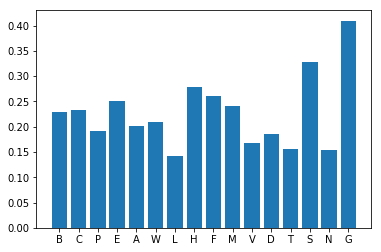

In [72]:
plt.bar(categories_f, proportions_f)

<BarContainer object of 30 artists>

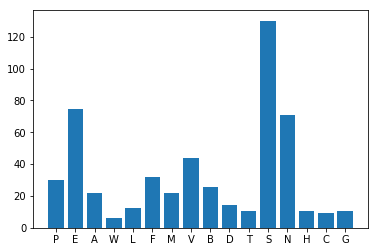

In [73]:
plt.bar(categories_p, proportions_p)

In [74]:
# Calculate the Causal Risk Ratio, Risk Difference, and Odds ratio for the data, with and without IP weighting

# Without IP Weighting

# Calculate P[Y = 1 | A = 1], proportion > mean given app is paid
sumProportionPaid = 0
numPaid = 0
# Calculate P[Y = 1 | A = 0], proportion > mean given app is free
sumProportionFree = 0
numFree = 0

for app in install_proportion:
    # [Proportion, Price, Installs, Category, Type]
    # install_proportion
    if app[4] == 'Free':
        numFree += 1
        sumProportionFree += app[0]
    else:
        numPaid += 1
        sumProportionPaid += app[0]

# Calculate the causal risk difference
probPaid = sumProportionPaid / numPaid
probFree = sumProportionFree / numFree

causalRiskDifference = probPaid - probFree
causalRiskRatio = probPaid / probFree

causalOddsRatio = (probPaid / (1 - probPaid)) / (probFree / (1 - probFree))

print("Causal Risk Difference: ", causalRiskDifference)
print("Causal Risk Ratio: ", causalRiskRatio)
print("Causal Odds Ratio: ", causalOddsRatio)


Causal Risk Difference:  -2.9371925444540703e-05
Causal Risk Ratio:  1.000283427281343
Causal Odds Ratio:  1.0002568065525805


In [75]:
# Calculate the Causal Risk Ratio, Risk Difference, and Odds ratio for the data, with and without IP weighting

# With IP Weighting

# Calculate P[Y = 1 | A = 1], proportion > mean given app is paid
sumProportionPaid = 0
numPaid = 0
# Calculate P[Y = 1 | A = 0], proportion > mean given app is free
sumProportionFree = 0
numFree = 0

for app in install_proportion:
    
    # [Proportion, Price, Installs, Category, Type]
    # install_proportion
    if app[0] >= 0:
        if app[4] == 'Free':
            numFree += 1
            sumProportionFree += app[0] * freeDict[app[3]]
        else:
            numPaid += 1
            sumProportionPaid += app[0] * paidDict[app[3]]
            
# Calculate the causal risk difference
probPaid = sumProportionPaid / numPaid
probFree = sumProportionFree / numFree

causalRiskDifference = probPaid - probFree
causalRiskRatio = probPaid / probFree

causalOddsRatio = (probPaid / (1 - probPaid)) / (probFree / (1 - probFree))

print("Causal Risk Difference: ", causalRiskDifference)
print("Causal Risk Ratio: ", causalRiskRatio)
print("Causal Odds Ratio: ", causalOddsRatio)

Causal Risk Difference:  1.511129267650195
Causal Risk Ratio:  44.56214680234508
Causal Odds Ratio:  -78.81070953164091


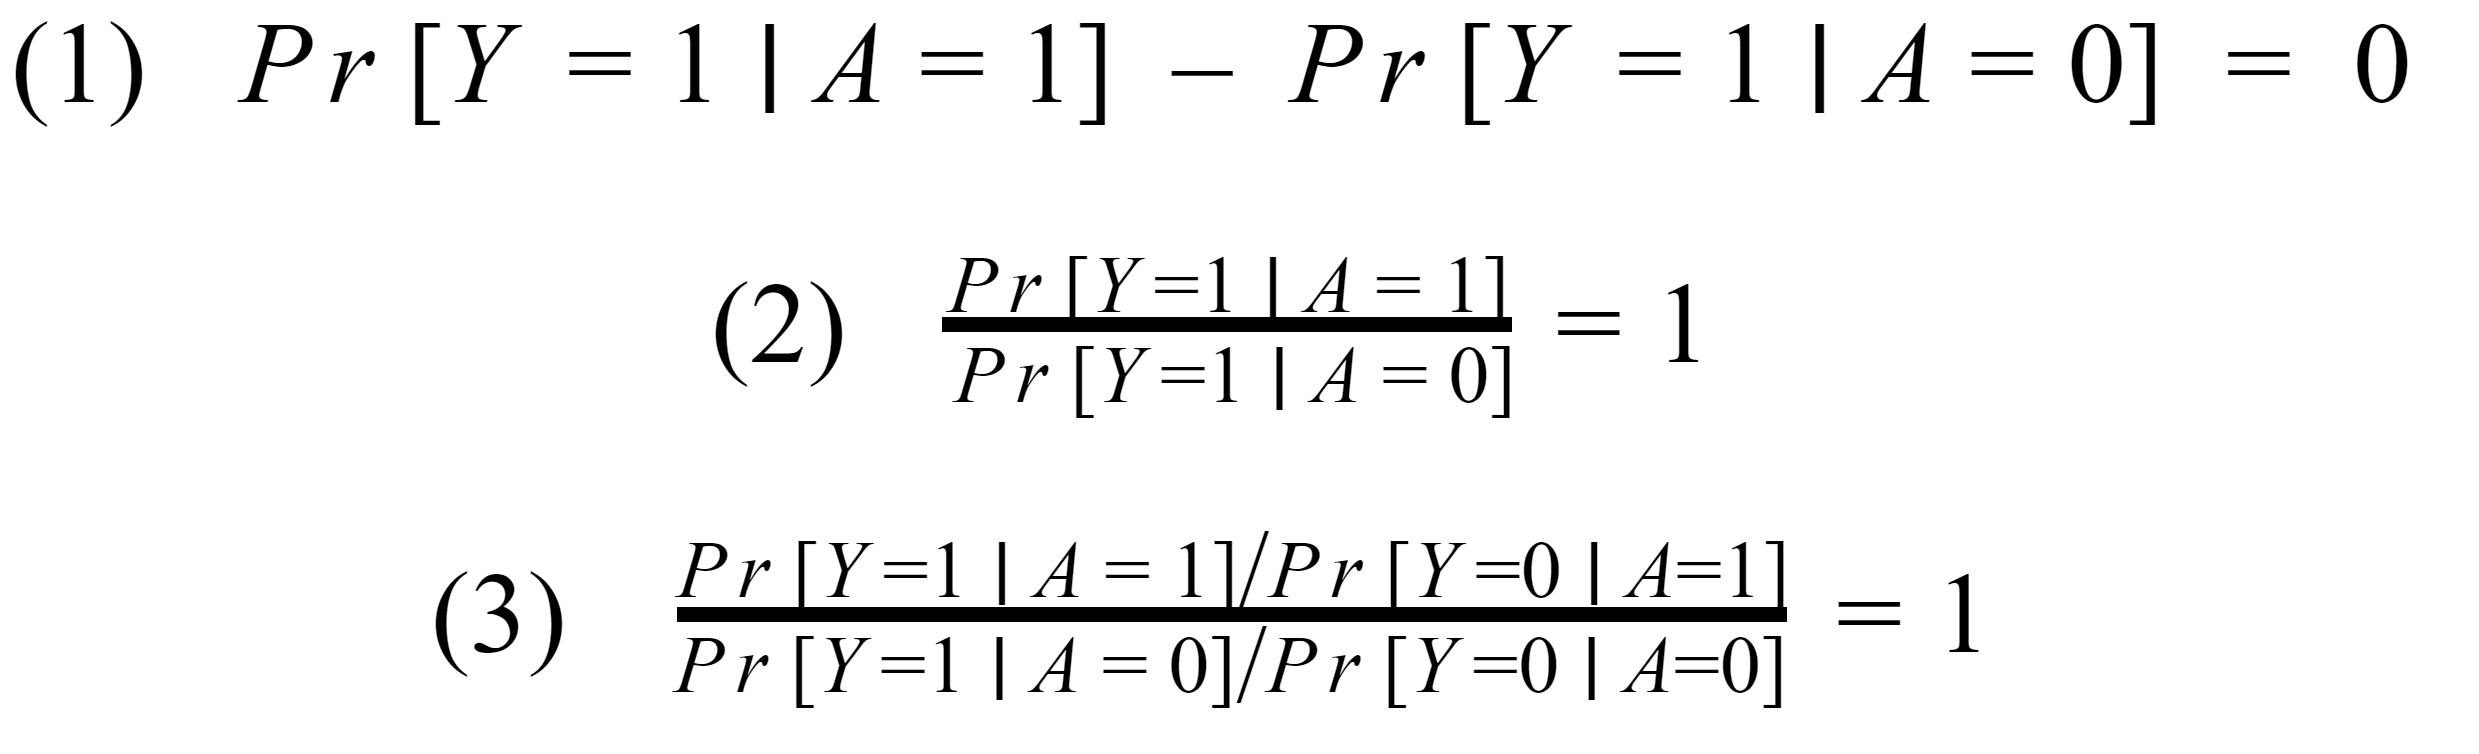